## Setup

To get started with the image classification, please install and import the following modules:

In [1]:
%pip install tensorflow_datasets

import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from urllib.parse import urlparse

Note: you may need to restart the kernel to use updated packages.


2024-08-28 20:30:00.595145: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 20:30:00.595207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 20:30:00.596633: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-28 20:30:00.604888: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-28 20:30:01.620946: W tensorflow/comp

In [2]:
print(tf.__version__)

2.15.0


### Download the flowers dataset

This tutorial uses a dataset of several thousand photos of flowers. The flowers dataset contains five sub-directories, one per class:

```
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

Note: all images are licensed CC-BY, creators are listed in the LICENSE.txt file.

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

After downloading (218MB), you should now have a copy of the flower photos available. There are 3,670 total images:

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3672


Each directory contains images of that type of flower. Here are some roses:

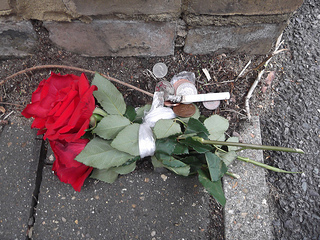

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

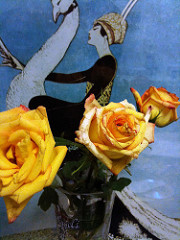

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

## Load data using a Keras utility

Let's load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. You will use 80% of the images for training and 20% for validation.

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3672 files belonging to 6 classes.
Using 2938 files for training.


2024-08-28 20:30:26.681760: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3672 files belonging to 6 classes.
Using 734 files for validation.


You can find the class names in the `class_names` attribute on these datasets.

In [10]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'jasmine', 'roses', 'sunflowers', 'tulips']


### Visualize the data

Here are the first nine images from the training dataset.

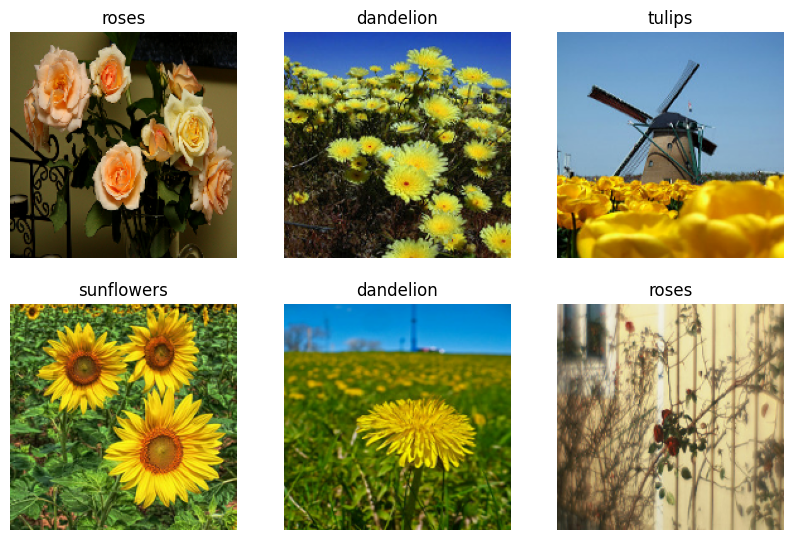

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint32"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You can train a model using these datasets by passing them to `model.fit` (shown later in this tutorial). If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on either of these tensors to convert them to a `numpy.ndarray`.

### Standardize the data


The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [13]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

### Configure dataset for performance

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be added using the `tf.data` API. For more details, visit the [Input Pipeline Performance](../../guide/performance/datasets.ipynb) guide.

In [14]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  #ds = ds.batch(batch_size) #This parameter must be implemented along a specific input pipeline during training (parallely loading more chunks at the same time)
  ds = ds.prefetch(buffer_size= tf.data.AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

### Train a model

For completeness, you will show how to train a simple model using the datasets you have just prepared.

The [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned in any way—the goal is to show you the mechanics using the datasets you just created. To learn more about image classification, visit the [Image classification](../images/classification.ipynb) tutorial.

In [15]:
num_classes = 6 

model = tf.keras.Sequential([
  normalization_layer, #brings x,y ∈ [0,255] to x,y ∈ [0,1] by dividing for 255 (max RGB value)

  tf.keras.layers.Conv2D(32, 3, activation='relu'), #3 conv layers for 3 channels, see https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D  ##32 filter ? ,3 (dimensione dell'array di convoluzione)
  tf.keras.layers.MaxPooling2D(), #see https://deepai.org/machine-learning-glossary-and-terms/max-pooling

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Flatten(), #trasforma i layer convoluzionali in array a 1 dimensione
  tf.keras.layers.Dense(128, activation='relu'), #128 la dimensione dell'immagine
  tf.keras.layers.Dense(num_classes) #il risultato, pari al numero delle classi che otteniamo
])

Choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [16]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10 #10 is the right number of epochs
)

Epoch 1/10
92/92 [==============================] - 68s 690ms/step - loss: 1.2868 - accuracy: 0.4309 - val_loss: 1.1125 - val_accuracy: 0.5354
Epoch 2/10
92/92 [==============================] - 66s 712ms/step - loss: 1.0248 - accuracy: 0.5848 - val_loss: 1.0172 - val_accuracy: 0.6131
Epoch 3/10
92/92 [==============================] - 56s 614ms/step - loss: 0.8865 - accuracy: 0.6576 - val_loss: 0.9865 - val_accuracy: 0.6349
Epoch 4/10
92/92 [==============================] - 51s 555ms/step - loss: 0.7536 - accuracy: 0.7059 - val_loss: 0.9583 - val_accuracy: 0.6471
Epoch 5/10
92/92 [==============================] - 54s 591ms/step - loss: 0.5785 - accuracy: 0.7880 - val_loss: 0.9769 - val_accuracy: 0.6349
Epoch 6/10
92/92 [==============================] - 54s 592ms/step - loss: 0.4166 - accuracy: 0.8502 - val_loss: 1.1169 - val_accuracy: 0.6540
Epoch 7/10
92/92 [==============================] - 57s 623ms/step - loss: 0.2671 - accuracy: 0.9139 - val_loss: 1.2498 - val_accuracy: 0.6594

Also, let's evaluate our model with the `model.evaluate` function:

In [17]:
model.evaluate(val_ds)

23/23 [==============================] - 3s 121ms/step - loss: 1.9045 - accuracy: 0.6417


[1.9044551849365234, 0.6416893601417542]

# Making predictions on the model just built

Let's now use `model.predict` and `tf.nn.softmax` to predict class percentiles, while selecting the highest:

In [19]:
# loads a never seen image from the internet

url = input("Insert a URL: ")

url_file_name = urlparse(url)
path = tf.keras.utils.get_file(os.path.basename(url_file_name.path), origin=url)


# loads the image into the img variable

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)

# converts the image into a tensor

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

# making the actual prediction over the tensor, choosing

predictions = model.predict(img_array) # builds the logit (raw scores)
print(predictions)
score = tf.nn.softmax(predictions[0]) # assigns probabilities to logits
print(score)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 31ms/step
[[ -1.38858    15.363847  -13.300963   -1.7270353   9.78186     1.190375 ]]
tf.Tensor(
[5.2830092e-08 9.9624830e-01 3.5432247e-13 3.7661025e-08 3.7509536e-03
 6.9647763e-07], shape=(6,), dtype=float32)
This image most likely belongs to dandelion with a 99.62 percent confidence.


Note: You can also write a custom training loop instead of using `Model.fit`. To learn more, visit the [Writing a training loop from scratch](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch) tutorial.

You may notice the validation accuracy is low compared to the training accuracy, indicating your model is overfitting. You can learn more about overfitting and how to reduce it in this [tutorial](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).